<a href="https://colab.research.google.com/github/nastjamakh/projects/blob/hollywood-age-gap/04-hollywood-age-gap/notebooks/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

## Color Palette

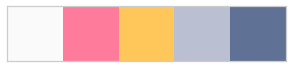

In [93]:
COLOR_BACKGROUND = '#fafafa'
ACCENT_COLORS = ['#FF7B9C', '#FFC759']
MUTED_COLORS = ['#BABFD1', '#607196']
COLORS = [*ACCENT_COLORS, *MUTED_COLORS]
COLOR_PALETTE = sns.color_palette(COLORS, as_cmap=True)
sns.palplot([COLOR_BACKGROUND] + COLORS)

In [3]:
# set background color
plt.rcParams['axes.facecolor']= COLOR_BACKGROUND
plt.rcParams['savefig.facecolor']= COLOR_BACKGROUND

In [4]:
def random_color(accent=True):
    c = ACCENT_COLORS if accent else MUTED_COLORS
    return np.random.choice(c)

random_color()

'#FF7B9C'

## Load data

# hollywoodagegap.com data

In [5]:
URL_MOVIE_DESCRIPTION = 'https://datasets.imdbws.com/title.basics.tsv.gz'
URL_MOVIE_RATINGS = 'https://datasets.imdbws.com/title.ratings.tsv.gz'
URL_ACTORS = 'https://datasets.imdbws.com/title.principals.tsv.gz'
URL_ACTOR_NAMES = 'https://datasets.imdbws.com/name.basics.tsv.gz'
URL_HOLLYWOOD_AGE = 'https://hollywoodagegap.com/movies.csv'

In [ ]:
df_hollywood = pd.read_csv(URL_HOLLYWOOD_AGE)
df_hollywood.drop(['Director', 'Age Difference'], axis=1, inplace=True)
df_hollywood['Actor 1 Birthdate'] = pd.to_datetime(df_hollywood['Actor 1 Birthdate']).dt.year
df_hollywood['Actor 2 Birthdate'] = pd.to_datetime(df_hollywood['Actor 2 Birthdate']).dt.year

df_hollywood['actor_1_older'] = df_hollywood['Actor 1 Birthdate'] > df_hollywood['Actor 2 Birthdate']
df_hollywood['actor_1_is_man'] = df_hollywood['Actor 1 Gender'] == 'man'
df_hollywood['actor_2_is_man'] = df_hollywood['Actor 2 Gender'] == 'man'
df_hollywood = df_hollywood.query('actor_1_is_man != actor_2_is_man')

df_hollywood['actor'] = df_hollywood.apply(lambda r: r['Actor 1 Name'] if r.actor_1_is_man else r['Actor 2 Name'], axis=1)
df_hollywood['actress'] = df_hollywood.apply(lambda r: r['Actor 1 Name'] if not r.actor_1_is_man else r['Actor 2 Name'], axis=1)

df_hollywood['actor_birth_year'] = df_hollywood.apply(lambda r: r['Actor 1 Birthdate'] if r.actor_1_is_man else r['Actor 2 Birthdate'], axis=1)
df_hollywood['actress_birth_year'] = df_hollywood.apply(lambda r: r['Actor 1 Birthdate'] if not r.actor_1_is_man else r['Actor 2 Birthdate'], axis=1)

df_hollywood['actor_age'] =  df_hollywood['Release Year'] - df_hollywood.actor_birth_year
df_hollywood['actress_age'] = df_hollywood['Release Year'] - df_hollywood.actress_birth_year

df_hollywood = df_hollywood.drop(['Actor 1 Name', 'Actor 1 Gender', 'Actor 1 Birthdate', 'Actor 1 Age', 'Actor 2 Name', 'Actor 2 Gender',
                   'Actor 2 Birthdate', 'Actor 2 Age', 'actor_1_older', 'actor_1_is_man',
                   'actor_2_is_man'], axis=1)

df_hollywood.columns = ['primary_title', 'release_year', 'actor', 'actress', 'actor_birth_year',
                        'actress_birth_year', 'actor_age', 'actress_age']

df_hollywood['age_gap'] = df_hollywood.actress_birth_year - df_hollywood.actor_birth_year
df_hollywood.head(3)

,primary_title,release_year,actor,actress,actor_birth_year,actress_birth_year,actor_age,actress_age,age_gap
0,Harold and Maude,1971,Bud Cort,Ruth Gordon,1948,1896,23,75,-52
1,Venus,2006,Peter O'Toole,Jodie Whittaker,1932,1982,74,24,50
2,The Quiet American,2002,Michael Caine,Do Thi Hai Yen,1933,1982,69,20,49


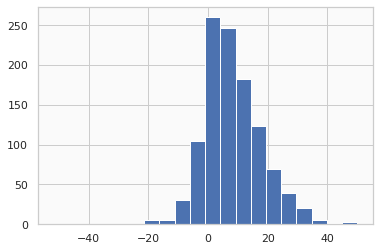

In [ ]:
df_hollywood.age_gap.hist(bins=20)

# IMDB Dataset

In [ ]:
df_movies = pd.read_csv(URL_MOVIE_DESCRIPTION, sep='\t')
df_ratings = pd.read_csv(URL_MOVIE_RATINGS, sep='\t')
df_actors = pd.read_csv(URL_ACTORS, sep='\t')
df_actor_names = pd.read_csv(URL_ACTOR_NAMES, sep='\t')
df.hollywood = pd.read_csv(URL_HOLLYWOOD_AGE)

df = df_movies.merge(df_ratings, on='tconst', how='left')
del df_movies, df_ratings

df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,1846.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.0,239.0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1615.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",6.0,155.0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2437.0


In [ ]:
# use np.nan instead of string fill value
df = df.replace('\\N',np.NaN)

# Filter out non-movies and porn movies
df = df.query('(titleType == "movie") and (isAdult ==0)')

# preprocess columns
df = df.drop(['titleType', 'isAdult', 'endYear'], axis=1)
df.columns = ['movie_id', 'primary_title', 'original_title', 'release_year', 'duration', 'genres',
             'rating', 'num_votes']

df.head(3)

,movie_id,primary_title,original_title,release_year,duration,genres,rating,num_votes
498,tt0000502,Bohemios,Bohemios,1905,100,NaN,4.5,14.0
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.1,744.0
587,tt0000591,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.2,16.0


In [ ]:
# preprocess year
df = df[df.release_year.notnull()]
df.release_year = df.release_year.astype(int)
df = df.query('release_year >= 1960')
print(f'Dataset contains {df.shape[0]:,} movies released since 1960')

# remove movies that were not released yet
df = df[df.release_year < 2022]

Dataset contains 369,089 movies released since 1960


In [ ]:
# extract romance genre
print(f'{round(df.genres.isnull().sum() / df.shape[0] * 100,2)}% have no genre information.')
df = df[df.genres.notnull()]
df['is_romance'] = df.genres.str.lower().str.contains('romance')

pct_romance = df.is_romance.sum() / df.shape[0] * 100
print(f'{round(pct_romance,2)}% of movies have romantic plot.')

0.0% have no genre information.
8.47% of movies have romantic plot.


Text(0.5, 1.0, 'Proportion of Romantic Movies')

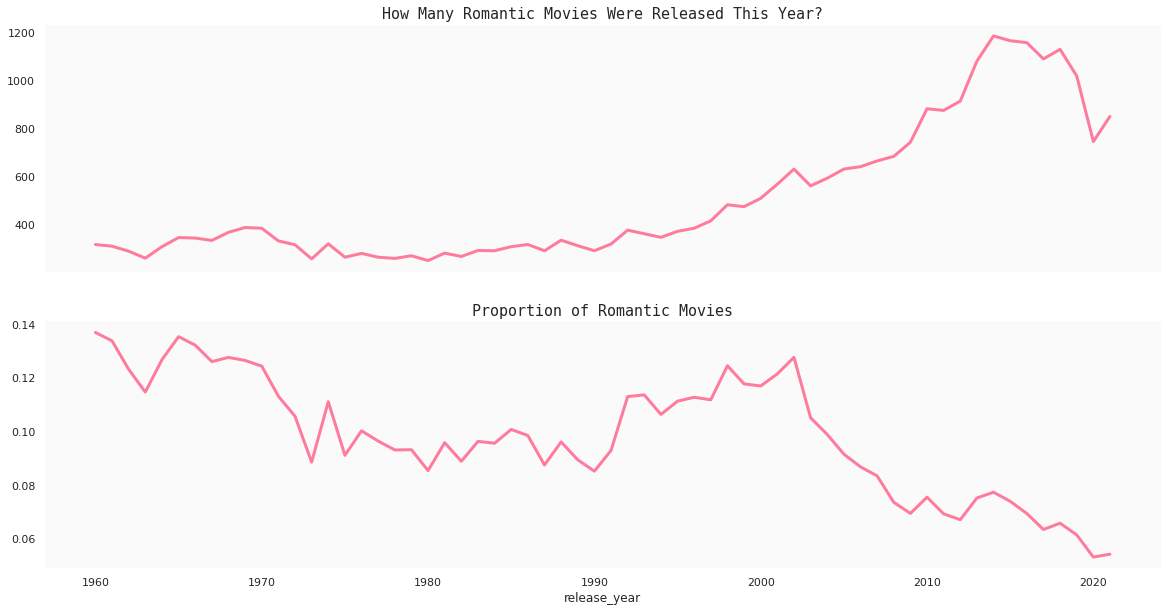

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)

# plot 1: absolute
df.groupby('release_year').is_romance.sum().plot(color=random_color(True), lw=3, ax=axs[0])
sns.despine(bottom = True, left = True)
axs[0].set_title('How Many Romantic Movies Were Released This Year?', fontsize=15, fontfamily='monospace')

#plot 2: percentages
df.groupby('release_year').apply(lambda year: year.is_romance.sum() / year.shape[0])\
        .plot(color=random_color(True), lw=3, ax=axs[1])
sns.despine(bottom = True, left = True)
axs[1].set_title('Proportion of Romantic Movies', fontsize=15, fontfamily='monospace')

## Add Ratings

In [ ]:
df_romances = df.query('is_romance')
df_romances.head(3)

,movie_id,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance
15487,tt0015724,Dama de noche,Dama de noche,1993,102,"Drama,Mystery,Romance",6.2,25.0,True
34805,tt0035423,Kate & Leopold,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",6.4,82503.0,True
46189,tt0047027,La gitana y el charro,La gitana y el charro,1964,87,"Comedy,Musical,Romance",4.8,15.0,True


In [ ]:
# remove when duration over 3 hours 
# preprocess duration
df_romances = df_romances[df_romances.duration.notnull()]
df_romances.duration = df_romances.duration.astype(int)
df_romances = df_romances[df_romances.duration <= 180]

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_romances = df_romances[df_romances.duration >= 60]

Text(0.5, 1.0, 'How Long are the Romantic Movies?')

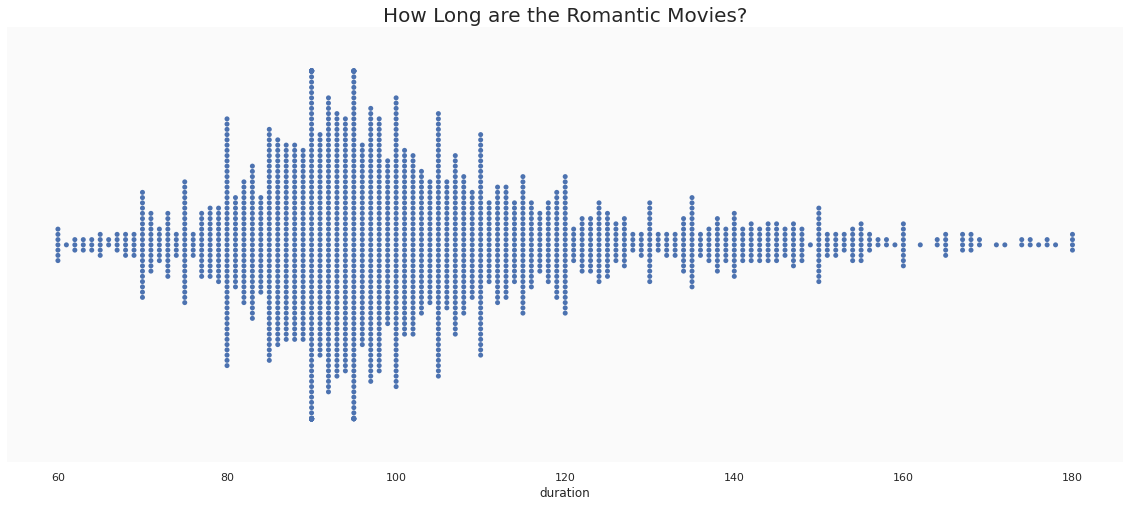

In [ ]:
SAMPLE_SIZE = 2000

plt.figure(figsize=(20,8))
sns.swarmplot(x=df_romances.sample(SAMPLE_SIZE).duration, dodge=True)
sns.despine(bottom = True, left = True)
plt.grid(False)
plt.title('How Long are the Romantic Movies?', fontsize=20)

In [ ]:
def noisy_rating(rating):
  sign = np.random.choice([-1,1])
  value = np.random.uniform(0,0.5)
  return rating + sign*value

noisy_rating(6.7)

6.459682232969023

Text(0.5, 1.0, 'How Romantic Movies Are Rated?')

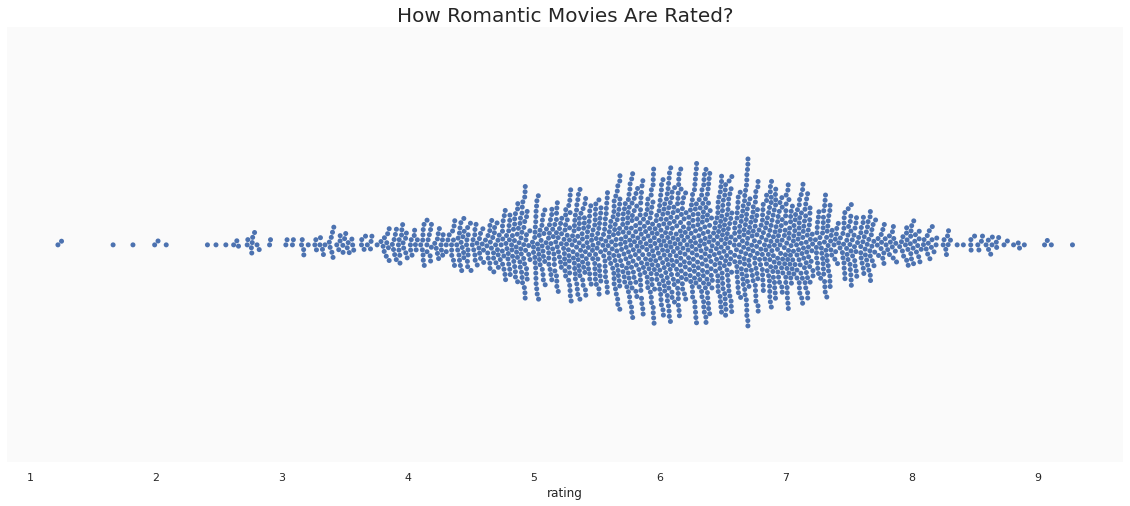

In [ ]:
SAMPLE_SIZE = 2000

plt.figure(figsize=(20,8))
sns.swarmplot(x=df_romances.sample(SAMPLE_SIZE).rating.apply(lambda r: noisy_rating(r)), dodge=True)
sns.despine(bottom = True, left = True)
plt.grid(False)
plt.title('How Romantic Movies Are Rated?', fontsize=20)

In [ ]:
num_no_votes = df_romances[df_romances.num_votes.isnull()].shape[0] / df.shape[0] * 100
print(f'{round(num_no_votes,2)}% of movies have no votes on IMDB.')

df_romances = df_romances[df.num_votes.notnull()]
df_romances.shape[0]

0.98% of movies have no votes on IMDB.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


21541

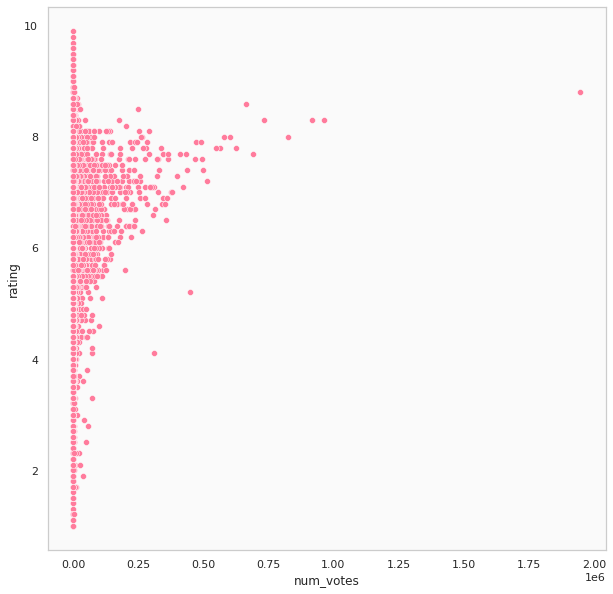

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_romances, x='num_votes', y='rating', color=random_color())

In [ ]:
pct_foreign = df_romances[df_romances.primary_title != df_romances.original_title].shape[0] / df_romances.shape[0]
df_romances = df_romances.query('primary_title == original_title')

In [ ]:
TOP_YEAR = 20
data = df_romances.groupby('release_year')\
    .apply(lambda y: y.sort_values(by='num_votes', ascending=False).iloc[:TOP_YEAR])\
    .set_index('movie_id').sort_values(by='release_year', ascending=False)
data.head()

,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance
movie_id,,,,,,,,
tt8231668,Good on Paper,Good on Paper,2021,92,"Comedy,Romance",5.6,10672.0,True
tt9766332,Atrangi Re,Atrangi Re,2021,138,"Comedy,Drama,Romance",6.7,18270.0,True
tt10293406,The Power of the Dog,The Power of the Dog,2021,126,"Drama,Romance,Western",7.0,72069.0,True
tt8847712,The French Dispatch,The French Dispatch,2021,107,"Comedy,Drama,Romance",7.3,63765.0,True
tt10752004,Love Hard,Love Hard,2021,104,"Comedy,Romance",6.3,44818.0,True


## Add Actors and Age

In [ ]:
def get_main_couple(movie):
  if ('actress' not in movie.category.unique()) or ('actor' not in movie.category.unique()):
    return None
  actress = movie.query('category == "actress"').nconst.iloc[0]
  actor = movie.query('category == "actor"').nconst.iloc[0]
  return {'actress': actress, 'actor': actor}

In [ ]:
LOAD_FROM_FILE = True

In [ ]:
if not LOAD_FROM_FILE:

  # Filter out non-romantic movies
  romantic_movies = data.index.tolist()
  actors = df_actors.query('tconst in @romantic_movies')
  assert actors.tconst.nunique() == len(romantic_movies)

  # Get IDs of actors and actresses
  actors = actors.groupby('tconst').apply(lambda movie: get_main_couple(movie))
  lead_actress = actors.apply(lambda l: None if not l else l['actress'])
  lead_actor = actors.apply(lambda l: None if not l else l['actor'])

  data['nconst_actress'] = lead_actress
  data['nconst_actor'] = lead_actor

  # Add actors' names
  data = data\
  .merge(df_actor_names[['nconst', 'primaryName', 'birthYear']], left_on='nconst_actor', right_on='nconst', how='left')\
  .rename(columns={'primaryName': 'actor', 'birthYear': 'actor_birth_year'})\
  .drop(['nconst'], axis=1)\
  .merge(df_actor_names[['nconst', 'primaryName', 'birthYear']], left_on='nconst_actress', right_on='nconst', how='left')\
  .rename(columns={'primaryName': 'actress', 'birthYear': 'actress_birth_year'})\
  .drop(['nconst_actress'], axis=1)

  # preprocess years
  data.actor_birth_year = data.actor_birth_year.replace('\\N', np.nan).astype(np.float).astype("Int32")
  data.actress_birth_year = data.actress_birth_year.replace('\\N', np.nan).astype(np.float).astype("Int32")

  # save to file
  data.to_csv('sample_data/top_romantic_movies_by_year.csv')

else:
  data = pd.read_csv('top_romantic_movies_by_year.csv', sep=';')\
  .drop('Unnamed: 0', axis=1)

data.head(3)

,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance,nconst_actor,actor,actor_birth_year,nconst_actress,actress,actress_birth_year,actress_age,actor_age,age_gap,actor_age_bin,actress_age_bin
0,Reminiscence,Reminiscence,2021,116,"Mystery,Romance,Sci-Fi",5.9,44138.0,True,nm0413168,Hugh Jackman,1968,nm0272581,Rebecca Ferguson,1983,38.0,53.0,15.0,"(50.0, 55.0]","(35.0, 40.0]"
1,Malcolm & Marie,Malcolm & Marie,2021,106,"Drama,Romance",6.7,33882.0,True,nm0913475,John David Washington,1984,nm3918035,Zendaya,1996,25.0,37.0,12.0,"(35.0, 40.0]","(20.0, 25.0]"
2,Locked Down,Locked Down,2021,118,"Comedy,Crime,Romance",5.2,10823.0,True,nm0252230,Chiwetel Ejiofor,1977,nm0004266,Anne Hathaway,1982,39.0,44.0,5.0,"(40.0, 45.0]","(35.0, 40.0]"


In [ ]:
data['actress_age'] = data.release_year - data.actress_birth_year
data['actor_age'] = data.release_year - data.actor_birth_year
data['age_gap'] = data.actress_birth_year - data.actor_birth_year

data = data.query('(actor_age > 14) & (actress_age > 14) & (actress_age < 75)')

data.head(3)

,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance,nconst_actor,actor,actor_birth_year,nconst_actress,actress,actress_birth_year,actress_age,actor_age,age_gap,actor_age_bin,actress_age_bin
0,Reminiscence,Reminiscence,2021,116,"Mystery,Romance,Sci-Fi",5.9,44138.0,True,nm0413168,Hugh Jackman,1968,nm0272581,Rebecca Ferguson,1983,38,53,15,"(50.0, 55.0]","(35.0, 40.0]"
1,Malcolm & Marie,Malcolm & Marie,2021,106,"Drama,Romance",6.7,33882.0,True,nm0913475,John David Washington,1984,nm3918035,Zendaya,1996,25,37,12,"(35.0, 40.0]","(20.0, 25.0]"
2,Locked Down,Locked Down,2021,118,"Comedy,Crime,Romance",5.2,10823.0,True,nm0252230,Chiwetel Ejiofor,1977,nm0004266,Anne Hathaway,1982,39,44,5,"(40.0, 45.0]","(35.0, 40.0]"


In [ ]:
data = pd.concat([data, df_hollywood]).reset_index(drop=True)
data = data.drop_duplicates('primary_title')

## **Analysis**

In [ ]:
data['man_is_older'] = data.actor_age >= data.actress_age
data['age_gap_noisy'] = data.age_gap.apply(lambda r: noisy_rating(r))

Text(20, 0.3, 'Who is Older?')

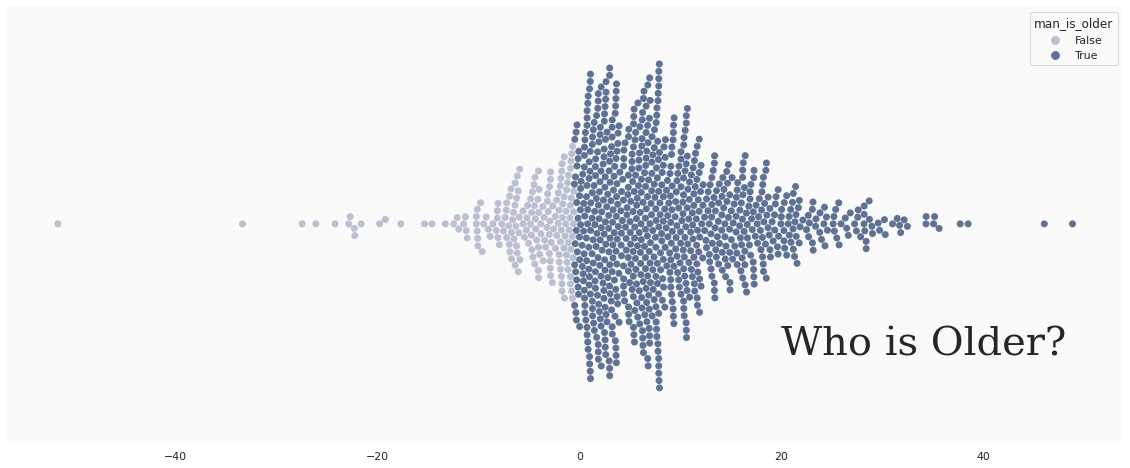

In [ ]:
SAMPLE_SIZE = 1000

plt.figure(figsize=(20,8))
sns.swarmplot(data=data.sample(SAMPLE_SIZE),
              x='age_gap_noisy',
              y=[""]*SAMPLE_SIZE,
              hue='man_is_older',
              size=7,
              palette=COLOR_PALETTE)
sns.despine(bottom = True, left = True)
plt.grid(False)
plt.xlabel(None)
plt.annotate('Who is Older?', fontsize=40, fontfamily='serif', xy=(20,0.3))

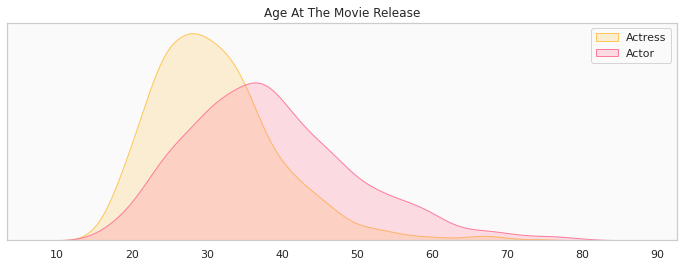

In [ ]:
plt.figure(figsize=(12,4))
sns.kdeplot(data.actress_age, fill=True, color=random_color(), label='Actress')
sns.kdeplot(data.actor_age, fill=True, color=random_color(True), label='Actor')

plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.grid(False)
plt.title('Age At The Movie Release')
plt.legend()

Text(0.5, 1.0, 'Actor Age by Release Date')

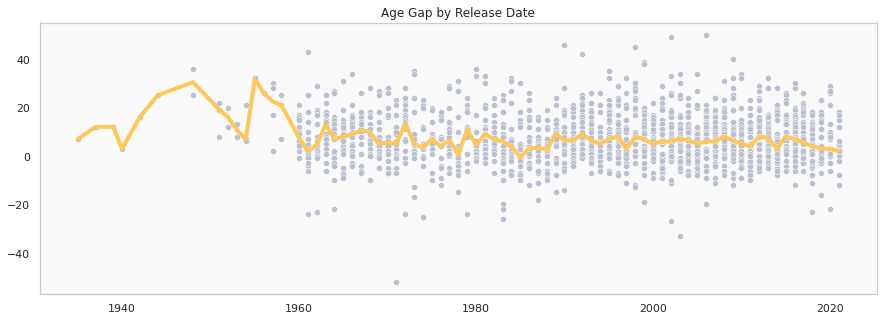

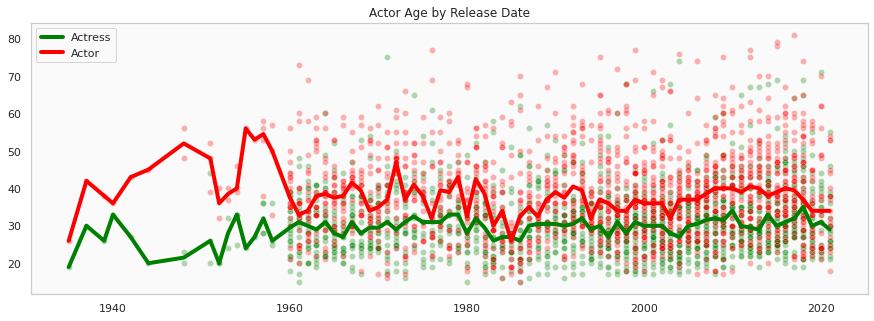

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=data, x='release_year', y='age_gap', ax=ax, color=random_color(False))
data.groupby('release_year').age_gap.median().plot(ax=ax, color=random_color(True), lw=4)

plt.grid(False)
plt.xlabel('')
plt.ylabel('')
plt.title('Age Gap by Release Date')

# actor age
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=data, x='release_year', y='actress_age',
                ax=ax, color='green', alpha=0.3)
sns.scatterplot(data=data, x='release_year', y='actor_age',
                ax=ax, color='red', alpha=0.3)
data.groupby('release_year').actress_age.median().plot(ax=ax, color='green',
                                                       lw=4, label='Actress')
data.groupby('release_year').actor_age.median().plot(ax=ax, color='red',
                                                     lw=4, label='Actor')

plt.grid(False)
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.title('Actor Age by Release Date')

# When is the Gap Too Creepy?

Your age divided by 2, plus 7

In [ ]:
vals = np.arange(14,85)
age_bounds = pd.DataFrame({'age': vals}, index=vals)
age_bounds['lower_bound'] = (age_bounds.age-7)*2
age_bounds['upper_bound'] = age_bounds.age/2 + 7
age_bounds.head(3)

,age,lower_bound,upper_bound
14,14,14,14.0
15,15,16,14.5
16,16,18,15.0


Text(0.5, 0, '')

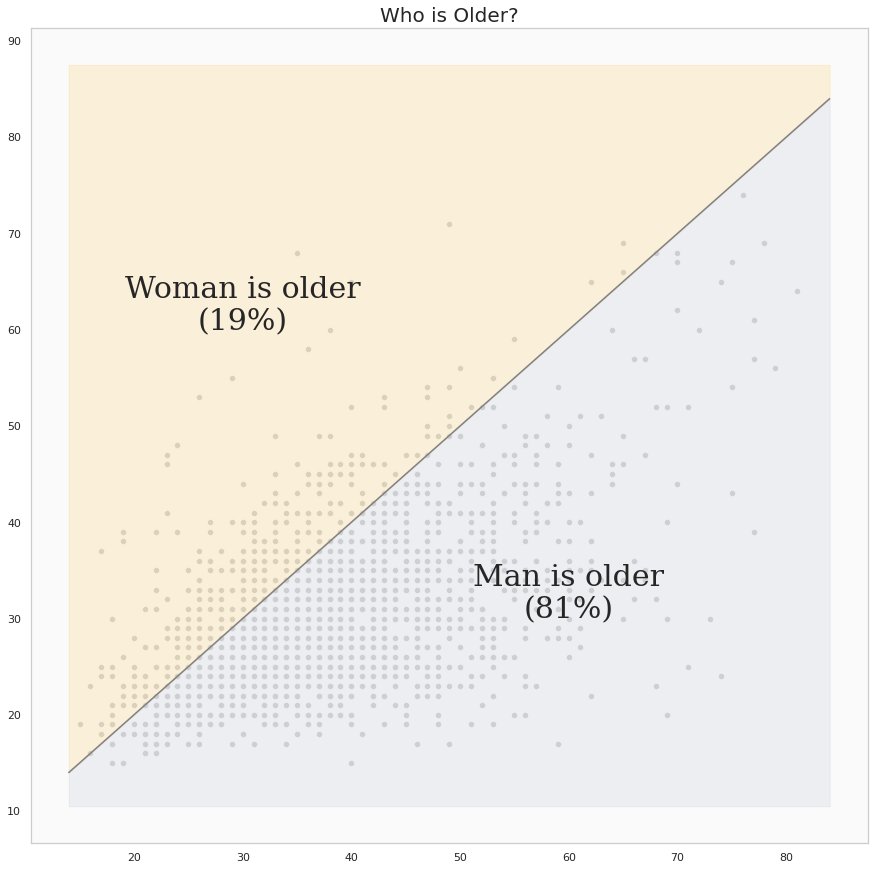

In [ ]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=data.query('actress_age < 75'), x='actor_age', y='actress_age',
                color='lightgrey')
color1 = random_color(True)
color2 = random_color(False)

age_bounds.age.plot(color='grey')

ymin, ymax = plt.ylim()
plt.fill_between(age_bounds.age, age_bounds.age, ymax,
                 alpha=0.2, color=color1)
plt.fill_between(age_bounds.age, age_bounds.age, ymin,
                 alpha=0.2, color=color2)

pct_man_older = int(round(data['man_is_older'].sum()/data.shape[0] * 100,0))

plt.annotate(f'Woman is older\n({100-pct_man_older}%)', xy=(30,60),
             fontsize=30, ha='center', fontfamily='serif')
plt.annotate(f'Man is older\n({pct_man_older}%)', xy=(60,30),
             fontsize=30, ha='center', fontfamily='serif')

plt.title('Who is Older?', fontsize=20)
plt.ylabel(None)
plt.xlabel(None)

In [ ]:
data['actress_above_upper_bound'] = data.apply(lambda row: row.actress_age > (row.actor_age-7)*2, axis=1)
data['actress_below_lower_bound'] = data.apply(lambda row: row.actress_age < row.actor_age/2+7, axis=1)
data['creepy_age_gap'] = data.actress_above_upper_bound | data.actress_below_lower_bound

Text(60, 20, 'He seems too old for her\n(81.0%)')

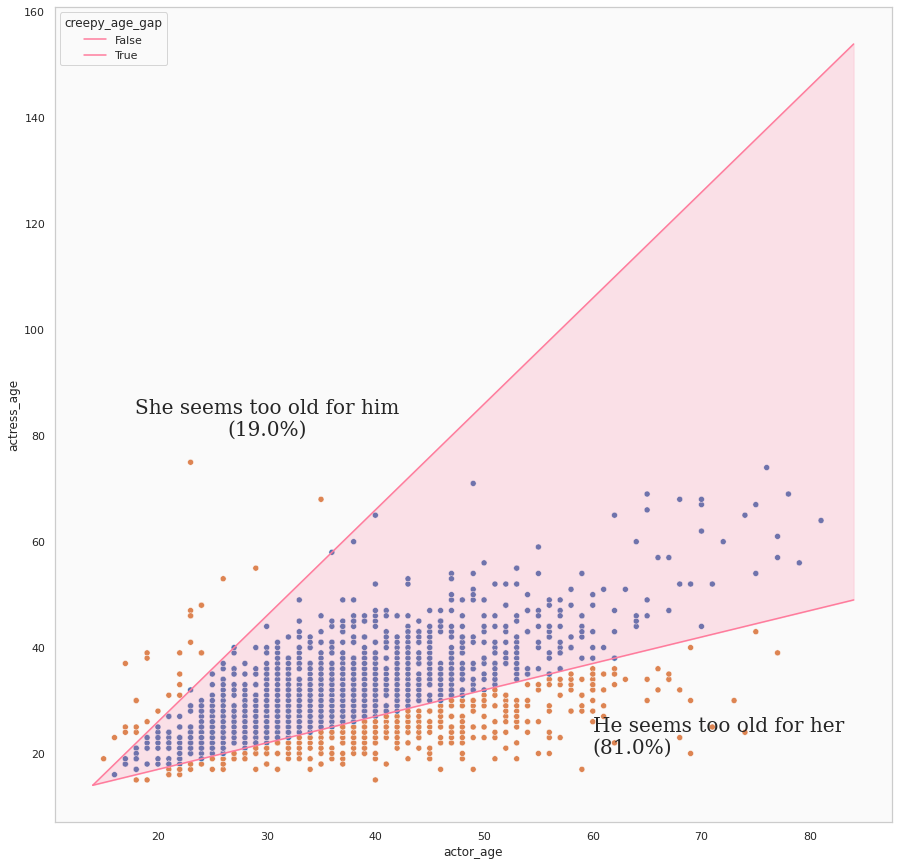

In [ ]:
color = random_color(True)

plt.figure(figsize=(15,15))
sns.scatterplot(data=data,
                x='actor_age', y='actress_age',
                hue='creepy_age_gap')

#age_bounds.age.plot()
age_bounds.lower_bound.plot(color=color)
age_bounds.upper_bound.plot(color=color)

totals = data.query('(actress_age > actress_above_upper_bound) or (actress_age < actress_below_lower_bound)')
pct_men = round(totals[totals.man_is_older].shape[0] / totals.shape[0] * 100, 0)
plt.fill_between(age_bounds.age, age_bounds.lower_bound, age_bounds.upper_bound,
                 alpha=0.2, color=color)

plt.annotate(f'She seems too old for him\n({100-pct_men}%)', xy=(30,80),
             fontsize=20, ha='center', fontfamily='serif')
plt.annotate(f'He seems too old for her\n({pct_men}%)', xy=(60,20),
             fontsize=20, ha='left', fontfamily='serif')

In [ ]:
data.actor_age = data.actor_age.astype(float)
data.actress_age = data.actress_age.astype(float)
data.age_gap = data.age_gap.astype(float)

In [ ]:
actor_age_bins = pd.cut(data.actor_age,bins=[0,14, 20,25,30,35,40,45,50,55,60,65,81])
actress_age_bins = pd.cut(data.actress_age,bins=[0,14,20,25,30,35,40,45,50,55,60,65,81])
data['actor_age_bin'] = actor_age_bins
data['actress_age_bin'] = actress_age_bins

Text(0.5, 0.98, 'How Old is the Romantic Partner?')

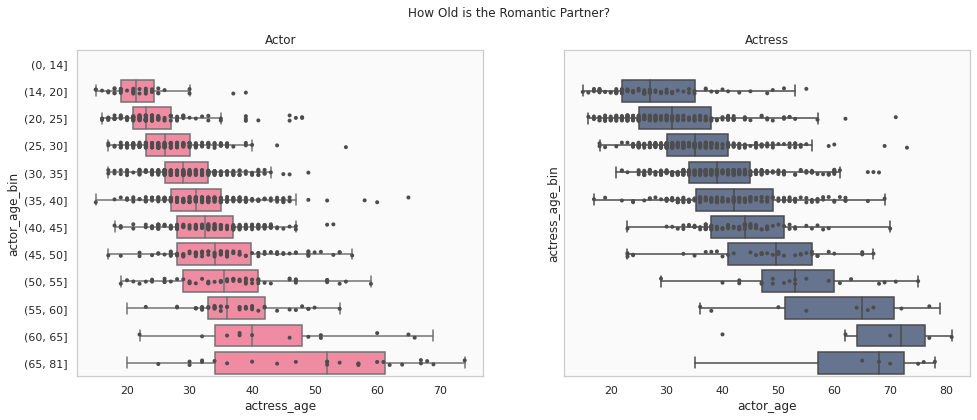

In [ ]:
color1 = random_color(True)
color2 = random_color(False)

fig, axs = plt.subplots(1,2, figsize=(16,6), sharey=True)

sns.boxplot(data=data, y='actor_age_bin', x='actress_age', showfliers=False, color=color1, ax=axs[0])
sns.stripplot(x="actress_age", y="actor_age_bin", data=data.dropna(),
              size=4, color=".3", linewidth=0, ax=axs[0])
axs[0].set_title('Actor')

sns.boxplot(data=data, y='actress_age_bin', x='actor_age', showfliers=False, color=color2, ax=axs[1])
sns.stripplot(x="actor_age", y="actress_age_bin", data=data.dropna(),
              size=4, color=".3", linewidth=0, ax=axs[1])
axs[1].set_title('Actress')

fig.suptitle('How Old is the Romantic Partner?')

In [ ]:
def is_too_old(age1, age2):
  return age1 > (age2-7)*2

Text(0.5, 1.0, 'Age Gap by Release Date')

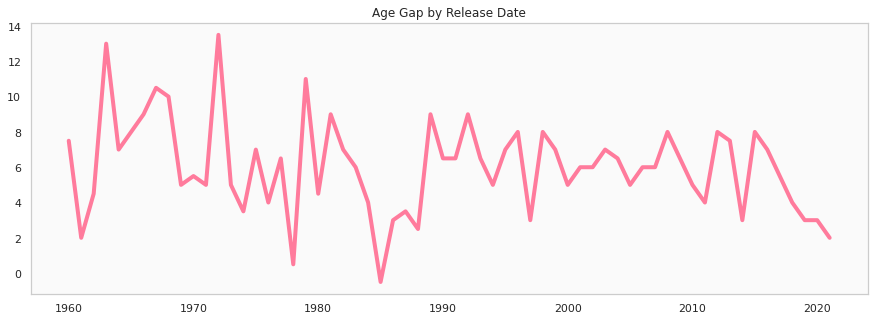

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
data.groupby('release_year').age_gap.median().loc[1960:].plot(ax=ax, color=random_color(True), lw=4)

plt.grid(False)
plt.xlabel('')
plt.ylabel('')
plt.title('Age Gap by Release Date')

# Oscar Nominies 1927-2018

In [6]:
df_actor_names = pd.read_csv(URL_ACTOR_NAMES, sep='\t')

In [13]:
df_actor_names = df_actor_names[['primaryName', 'birthYear']]
df_actor_names.columns = ['name', 'birth_year']
df_actor_names = df_actor_names.drop_duplicates('name')
df_actor_names.birth_year = df_actor_names.birth_year.replace('\\N', np.nan).astype('Float32')

df_actor_names.head(3)

,name,birth_year
0,Fred Astaire,1899
1,Lauren Bacall,1924
2,Brigitte Bardot,1934


In [18]:
df_actor_names.shape[0]

11333711

In [54]:
df_actor_names.loc[df_actor_names['name'] == "Jennifer Lawrence", 'birth_year'] = 1990
df_actor_names.loc[df_actor_names['name'] == "H. B. Warner", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Dame May Whitty", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Albert Basserman", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Larry Parks", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Oscar Homolka", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Sir Laurence Olivier", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Dame Edith Evans", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Michael Dunn", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Anouk Aimee", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Jocelyne Lagarde", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Genevieve Bujold", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Richard Castellano", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Howard E. Rollins, Jr.", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Louis Gossett, Jr.", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Noriyuki 'Pat' Morita", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Daniel Day Lewis", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Gerard Depardie", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Cuba Gooding, Jr.", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Amy Adams", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Ellen Page", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Richard Jenkins", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Felicity Jones", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Emma Stone", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Andrew Garfield", 'birth_year'] = 
df_actor_names.loc[df_actor_names['name'] == "Dev Patel", 'birth_year'] = 
df_actor_names.query('name == "Jennifer Lawrence"')

,name,birth_year
466011,Jennifer Lawrence,1990.0


In [39]:
df_oscar = pd.read_csv('data_csv.csv')
df_oscar.category = df_oscar.category.str.lower()
df_oscar = df_oscar[df_oscar.category.str.contains('actress|actor')]
df_oscar['category'] = df_oscar['category'].apply(lambda cat: 'actress' if 'actress' in cat else 'actor')
df_oscar = df_oscar.rename(columns={'entity': 'name'})
df_oscar['year'] = df_oscar['year'].astype(int)
df_oscar.head()

,year,category,winner,name
0,1927,actor,False,Richard Barthelmess
1,1927,actor,True,Emil Jannings
2,1927,actress,False,Louise Dresser
3,1927,actress,True,Janet Gaynor
4,1927,actress,False,Gloria Swanson


In [40]:
df_oscar.category.value_counts()

actress    856
actor      852
Name: category, dtype: int64

In [31]:
df_oscar.shape[0]

856

In [41]:
df_oscar = df_oscar.merge(df_actor_names, on='name', how='left')

In [55]:
df_oscar[df_oscar.birth_year.isnull()].name.unique()

array(['H. B. Warner', 'Dame May Whitty', 'Albert Basserman',
       'Larry Parks', 'Oscar Homolka', 'Sir Laurence Olivier',
       'Dame Edith Evans', 'Michael Dunn', 'Anouk Aimee',
       'Jocelyne Lagarde', 'Genevieve Bujold', 'Richard Castellano',
       'Howard E. Rollins, Jr.', 'Louis Gossett, Jr.',
       "Noriyuki 'Pat' Morita", 'Daniel Day Lewis', 'Gerard Depardieu',
       'Cuba Gooding, Jr.', 'Amy Adams', 'Ellen Page', 'Richard Jenkins',
       'Jennifer Lawrence', 'Felicity Jones', 'Emma Stone',
       'Andrew Garfield', 'Dev Patel'], dtype=object)

In [56]:
df_oscar['age'] = df_oscar['year'] - df_oscar['birth_year']

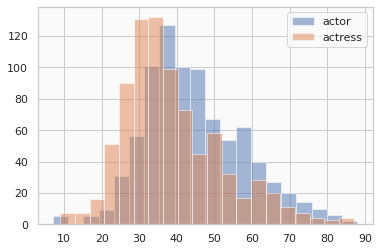

In [61]:
df_oscar.query('category == "actor"').age.hist(bins=20, alpha=0.5, label='actor')
df_oscar.query('category == "actress"').age.hist(bins=20, alpha=0.5, label='actress')

plt.legend()

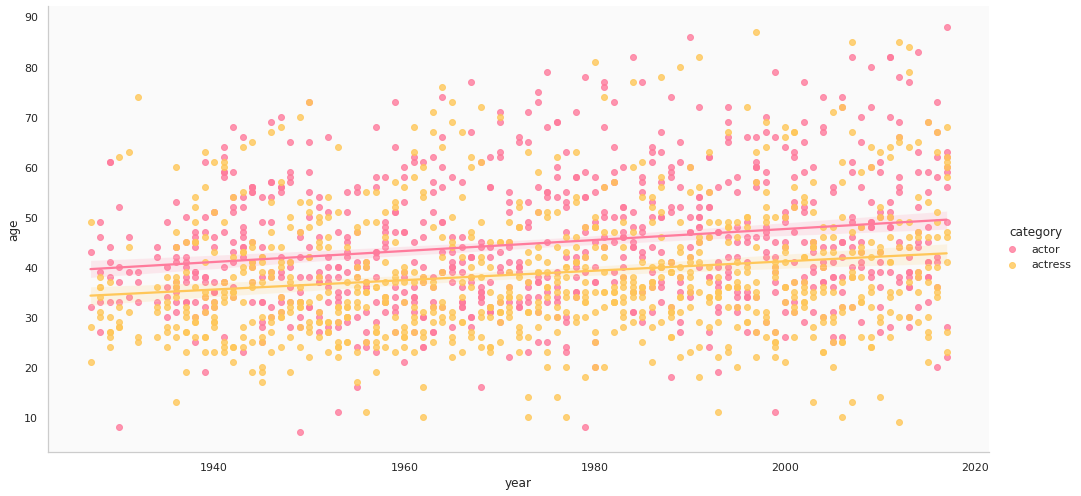

In [94]:
sns.lmplot(data=df_oscar, x='year', y='age', hue='category',
           height=7, aspect=2, palette=COLOR_PALETTE)

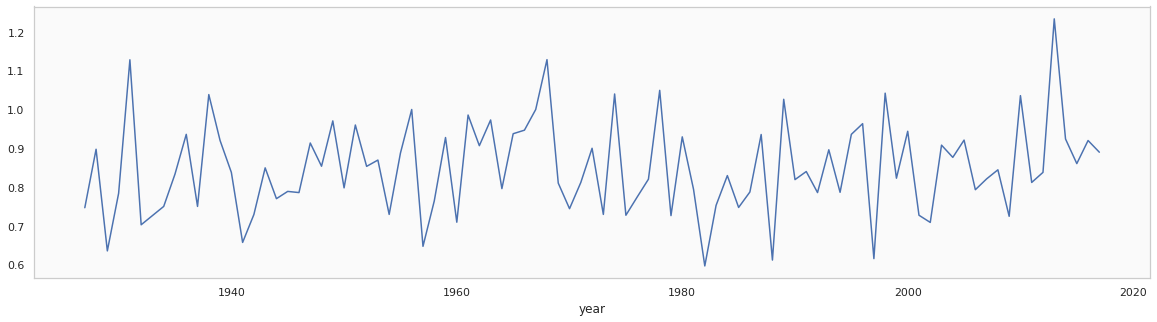

In [89]:
ages = df_oscar.groupby(['year', 'category']).median().age.unstack()
ages['ratio'] = ages.actress / ages.actor

plt.figure(figsize=(20,5))
ages['ratio'].plot()

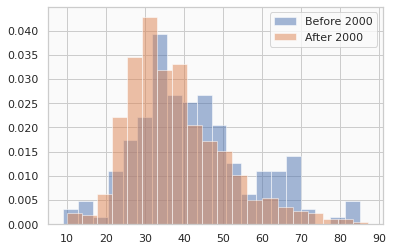

In [77]:
df_oscar.query('(year >= 2000) and (category == "actress")').age.hist(bins=20,
                                                                      alpha=0.5, density=True, label='Before 2000')
df_oscar.query('(year < 2000) and (category == "actress")').age.hist(bins=20,
                                                                     alpha=0.5, density=True, label='After 2000')

plt.legend()